In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import six
import tensorflow as tf

from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma,
    MultivariateNormalDiag, Normal, ParamMixture, Bernoulli, PointMass)

plt.style.use('ggplot')

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
class dataset(object):
    def __init__(self, N, M, D1, D2):
        self.N = N
        self.M = M
        self.D1 = D1
        self.D2 = D2
        self.Z = np.zeros((N,D1), dtype=np.float32)
        self.X = np.zeros((N,D2), dtype=np.float32)
        self.Y = np.zeros((N,1))
        self.C = np.zeros((N,1), dtype=np.float32)
        self.beta = None
        self.mus = None
        self.stds = None
        self.WX = None
        self.WY = None
        self.sigmaX = None
        
    def create(self):
        beta = np.random.dirichlet([1]*self.M)
        mus = np.random.randn(self.M, self.D1)*4
        stds = [[1, 1]]*self.M
        WX = np.random.randn(self.D1, self.D2)
        WY = np.random.randn(self.D1)
        sigmaX = [1,1,1]
        
        for n in range(self.N):
            c = np.argmax(np.random.multinomial(1, beta))
            self.C[n,:] = c
            self.Z[n, :] = np.random.multivariate_normal(mus[c], np.diag(stds[c]))
            self.X[n, :] = np.random.multivariate_normal(np.matmul(self.Z[n],WX), np.diag(sigmaX))
            self.Y[n,:] = np.random.binomial(1,1/(1+np.exp(-np.matmul(self.Z[n],WY))))

        
        self.beta = beta
        self.mus = mus
        self.stds = stds
        self.WX = WX
        self.WY = WY
        self.sigmaX = sigmaX

    def print_params(self):
        print("Cluster Probabilities:", self.beta)
        print("Centers:")
        for i in range(self.M):
            print(self.mus[i,:])
        print("X-Centers:")
        Xcenters = np.matmul(self.mus, self.WX)
        for i in range(Xcenters.shape[0]):
            print(Xcenters[i,:])
            
        
    def visualize(self):
        color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
        marker = ['x','+','0']
        for i in [0,1]:
            classpoints = np.where(self.Y==i)
            for j in range(self.M):
                points = np.where(self.C[classpoints]==j)
                Z = self.Z[classpoints[0],:]
                plt.plot(Z[points, 0], Z[points, 1], color[j]+marker[i])
#                 plt.axis([-20,20,-20,20])
                plt.title("Simulated dataset")
        plt.show()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i in [0,1]:
            classpoints = np.where(self.Y==i)
            for j in range(self.M):
                points = np.where(self.C[classpoints]==j)
                X = self.X[classpoints[0],:]
                plt.scatter(X[points, 0], X[points, 1], X[points,2],c=color[j], marker=marker[i])
        plt.show()

    def MAPdiagnostics(self, qmu=None, qwx=None, qwy=None, qc=None):
        sess = ed.get_session()
        print("Inferred prototypes axes:")
        data.print_params()
        print("________________________\n")
        zproto = sess.run(qmu.params)
        weightx = sess.run(qwx.params)
#         weighty = sess.run(qwy.params)
        xcenters = np.matmul(zproto,weightx.transpose())
        for i in range(zproto.shape[0]):
            print(i, zproto[i,:],xcenters[i,:])

    def VIdiagnostics(self, qmu=None, qwx=None, qwy=None, qc=None):
        sess = ed.get_session()
        probs = sess.run(qc.probs)
        cluster = np.argmax(probs, axis=1)
        clusterlabels = np.zeros([self.M, 10])
        for i in range(self.M):
            temp = Ytrain[np.where(cluster==i)]
            elem, count = np.unique(temp, return_counts=True)
            elem = elem.astype(int)
            for j in range(elem.shape[0]):
                clusterlabels[i,elem[j]] = count[j]

        zproto = sess.run(qmu.mean())
        dictionary = sess.run(qwx.mean())
        dictionary = np.matmul(zproto,dictionary.transpose())*Xscale+Xmean
        # np.place(dictionary, dictionary<0, 0)
        for i in range(dictionary.shape[0]):
            print(clusterlabels[i,:].astype(int))
            utils.show(dictionary[i,:].reshape((28,28)))
        

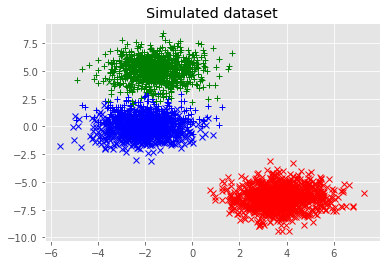

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


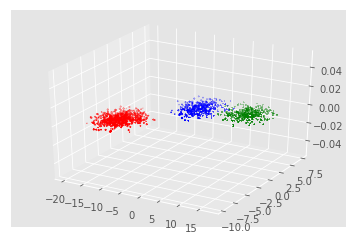

In [3]:
N = 3000
M = 3
D1 = 2
D2 = 3
inference = 'EM'
data = dataset(N, M, D1, D2)
data.create()
data.visualize()

In [4]:
beta = Dirichlet(tf.ones(M))
mu = Normal(tf.zeros(D1), tf.ones(D1), sample_shape=M)
sigmasq = InverseGamma(tf.ones(D1), tf.ones(D1), sample_shape=M)
z = ParamMixture(beta, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
c = z.cat
wx = Normal(loc=tf.zeros([D2, D1]), scale=tf.ones([D2, D1]))
wy = Normal(loc=tf.zeros([1, D1]), scale=tf.ones([1, D1]))
x = Normal(loc=tf.matmul(z, wx, transpose_b=True), scale=tf.ones([N, D2]))
y = Bernoulli(logits=tf.matmul(z, wy, transpose_b=True))

In [5]:
if inference == 'VI':
    qz = Normal(loc=tf.Variable(tf.random_normal([N, D1])),
                scale=tf.nn.softplus(tf.Variable(tf.random_normal([N, D1]))))
    qmu = Normal(loc=tf.Variable(tf.random_normal([M, D1])),
                scale=tf.nn.softplus(tf.Variable(tf.random_normal([M, D1]))))
    qwx = Normal(loc=tf.Variable(tf.random_normal([D2, D1])),
                scale=tf.nn.softplus(tf.Variable(tf.random_normal([D2, D1]))))
    qwy = Normal(loc=tf.Variable(tf.random_normal([1, D1])),
                scale=tf.nn.softplus(tf.Variable(tf.random_normal([1, D1]))))
    qc = Categorical(logits=tf.Variable(tf.zeros([N,M])))

    # inference = ed.MAP([mu,c], data={x: data.X, y: data.Y})
    inference = ed.KLqp({mu: qmu, c: qc}, data={x: data.X, y: data.Y})
    #  , z: qz, wy: qwy, wx: qwx
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
    inference.run(n_iter=500, n_print=100, n_samples=50,optimizer=optimizer)

    
if inference == 'MAP':
    qz = PointMass(params=tf.Variable(tf.random_normal([N, D1])))
    qmu = PointMass(params=tf.Variable(tf.random_normal([M, D1])))
    qwx = PointMass(params=tf.Variable(tf.random_normal([D2, D1])))
    qwy = PointMass(params=tf.Variable(tf.random_normal([1, D1])))
    qsigmasq = PointMass(params=tf.Variable(tf.ones([M,D1])))
    qc = PointMass(params=tf.Variable(tf.zeros(N)))
    inference = ed.MAP({mu:qmu, wx:qwx, wy:qwy, sigmasq:qsigmasq}, data={x: data.X, y: data.Y})
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
    inference.run(n_iter=5000, n_print=100, optimizer=optimizer)


if inference == 'EM':
    qz = Normal(loc=tf.Variable(tf.random_normal([N, D1])),
                scale=tf.nn.softplus(tf.Variable(tf.random_normal([N, D1]))))
    qc = Categorical(logits=tf.Variable(tf.zeros([N,M])))
    qmu = PointMass(params=tf.Variable(tf.random_normal([M, D1])))
    qwx = PointMass(params=tf.Variable(tf.random_normal([D2, D1])))
    qwy = PointMass(params=tf.Variable(tf.random_normal([1, D1])))
    qsigmasq = PointMass(params=tf.Variable(tf.ones([M,D1])))
    
    inference_e = ed.KLqp({z:qz,c:qc}, data={x: data.X, y: data.Y, mu:qmu, wx:qwx, wy:qwy, sigmasq:qsigmasq})
    inference_m = ed.MAP({mu:qmu, wx:qwx, wy:qwy, sigmasq:qsigmasq}, data={x: data.X, y: data.Y, c:qc, z:qz})
    inference_e.initialize(optimizer = tf.train.AdamOptimizer(learning_rate=1e-3))
    inference_m.initialize()

    init = tf.global_variables_initializer()
    init.run()
    
    for i in range(2000):
        for j in range(20):
            info_dict_e = inference_e.update()
        info_dict_m = inference_m.update()
        inference_m.print_progress(info_dict_m)

        
if inference == 'MCMC':
    T = 2000  # number of MCMC samples
    qz = Empirical(tf.Variable(tf.zeros([T, N, D1])))
    qmu = Empirical(tf.Variable(tf.zeros([T, M, D1])))
    qsigmasq = Empirical(tf.Variable(tf.ones([T, M, D1])))
    qwx = Empirical(tf.Variable(tf.random_normal([T, D2, D1])))
#     qwy = Empirical(tf.Variable(tf.random_normal([T, 1, D1])))
    inference = ed.Gibbs({mu: qmu, sigmasq: qsigmasq}, data={x: data.X, y:data.Y})
    inference.initialize()

    sess = ed.get_session()
    tf.global_variables_initializer().run()

    t_ph = tf.placeholder(tf.int32, [])
    running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)
    running_weight_means = tf.reduce_mean(qwx.params[:t_ph], 0)

    for _ in range(inference.n_iter):
      info_dict = inference.update()
      inference.print_progress(info_dict)
      t = info_dict['t']
      if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(tf.matmul(running_cluster_means, running_weight_means, transpose_b=True), {t_ph: t - 1}))
    data.print_params()

1000/1000 [100%] ██████████████████████████████ Elapsed: 142s | Loss: 198244.562

In [6]:
data.MAPdiagnostics(qmu, qwx,qwy)
# print(np.sum(np.argmax(sess.run(qc.probs), axis=1)==data.C[:,0]))

Inferred prototypes axes:
Cluster Probabilities: [ 0.35061711  0.28490474  0.36447815]
Centers:
[-2.00666326  0.11317753]
[-1.5738128   5.18309663]
[ 3.70815887 -6.45294749]
X-Centers:
[-0.63774543  1.94050691 -0.4372895 ]
[ 10.54966468   2.78574181   0.01308511]
[-12.36459806  -5.13488598   0.37169104]
________________________

0 [  1.24588841e-37   1.73896386e-37] [  6.22874925e-39  -1.33491055e-39   1.92259270e-39]
1 [ -6.11798174e-36   1.78169113e-37] [ -2.12812465e-38  -1.42478400e-37   3.81926054e-38]
2 [  2.40831145e-37  -2.89124688e-37] [ -8.37191334e-39   1.23407984e-38  -5.79467884e-39]


In [7]:
z_post = ed.copy(z, {c: qc, mu: qmu})
z_gen = sess.run(z_post)
plt.scatter(z_gen[:,0], z_gen[:, 1])
plt.show()

x_post = ed.copy(x, {wx: qwx, z: qz, c: qc, wy: qwy, mu: qmu})
x_gen = sess.run(x_post)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(x_gen[:,0], x_gen[:, 1], x_gen[:,2])
plt.show()

print(ed.evaluate('log_likelihood', data={x_post: data.X}))

NameError: name 'sess' is not defined